# IMPORTING LIBRARIES AND SETUP

In [10]:
# %pip install torch torchvision matplotlib pandas 
%pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Auto-reload modules so we don't have to restart the kernel if we change code
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
from time import time

# Import your custom modules
from model import MalariaCNN
from dataloading import create_dataloaders
from train import train_step
from evaluation import evaluate_step
from plotting import plot_sample_images, plot_results

# Config
DATA_PATH = 'cell_images'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

Running on: cpu


# LOADING DATASET

Classes found: ['Parasitized', 'Uninfected']
Visualizing Training Samples...


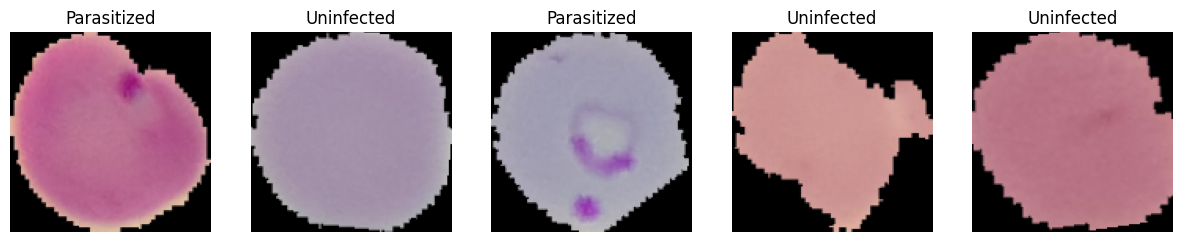

In [ ]:
# 1. Initialize Loaders
train_loader, val_loader, class_names = create_dataloaders(DATA_PATH, batch_size=32)

print(f"Classes found: {class_names}")
print(f"Training Batches: {len(train_loader)} | Validation Batches: {len(val_loader)}")

# 2. Visual Inspection (EDA)
print("\n Sample Microscopic Images (Normalized):")
plot_sample_images(train_loader, class_names)

# MODEL PREPARATION AND TRAINING

## 1 . Loading the Model

In [ ]:
model = MalariaCNN().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Model Architecture:")
print(model)

MalariaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## 2 . Training the Model

In [9]:
EPOCHS = 10
results = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

print(f"Starting training for {EPOCHS} epochs...")
start_time = time()

for epoch in range(EPOCHS):
    # 1. Train
    t_loss, t_acc = train_step(model, train_loader, criterion, optimizer, DEVICE)
    
    # 2. Evaluate
    v_loss, v_acc = evaluate_step(model, val_loader, criterion, DEVICE)
    
    # 3. Log
    results['train_loss'].append(t_loss)
    results['train_acc'].append(t_acc)
    results['val_loss'].append(v_loss)
    results['val_acc'].append(v_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Acc: {t_acc:.2f}% | Val Acc: {v_acc:.2f}% | Train Loss: {t_loss:.2f}% | Val Loss: {v_loss:.2f}%")

total_time = time() - start_time
print(f"\nTraining Complete in {total_time/60:.2f} minutes.")

Starting training for 10 epochs...
Epoch [1/10] | Train Acc: 89.14% | Val Acc: 95.32%
Epoch [2/10] | Train Acc: 95.54% | Val Acc: 95.52%
Epoch [3/10] | Train Acc: 95.80% | Val Acc: 95.50%
Epoch [4/10] | Train Acc: 96.02% | Val Acc: 95.63%
Epoch [5/10] | Train Acc: 96.13% | Val Acc: 95.92%
Epoch [6/10] | Train Acc: 96.28% | Val Acc: 95.57%
Epoch [7/10] | Train Acc: 96.28% | Val Acc: 95.45%
Epoch [8/10] | Train Acc: 96.33% | Val Acc: 95.77%
Epoch [9/10] | Train Acc: 96.59% | Val Acc: 95.85%
Epoch [10/10] | Train Acc: 96.76% | Val Acc: 94.52%

Training Complete in 3130.71 seconds.


# MODEL EVALUATION

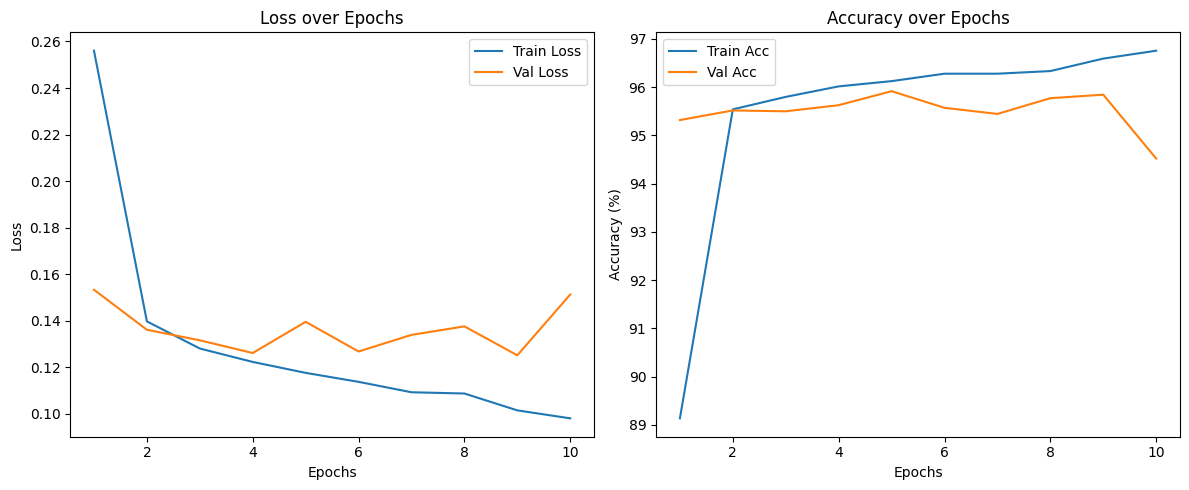

In [11]:
# Visualize Performance
plot_results(results)

# Save Model
# torch.save(model.state_dict(), 'malaria_cnn_v1.pth')
# print("Model saved to disk.")

# INFERENCE

In [12]:
# Let's grab one batch and predict on it
model.eval()
images, labels = next(iter(val_loader))
images = images.to(DEVICE)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

print("Checking a few predictions:")
for i in range(5):
    actual = class_names[labels[i]]
    predicted = class_names[preds[i]]
    result = "✅" if actual == predicted else "❌"
    print(f"Image {i+1}: Actual={actual} | Predicted={predicted} {result}")

# Save the trained model for future use
torch.save(model.state_dict(), 'malaria_cnn_final.pth')
print("\nModel saved to disk.")

Checking a few predictions:
Image 1: Actual=Parasitized | Predicted=Parasitized ✅
Image 2: Actual=Parasitized | Predicted=Parasitized ✅
Image 3: Actual=Uninfected | Predicted=Uninfected ✅
Image 4: Actual=Uninfected | Predicted=Uninfected ✅
Image 5: Actual=Uninfected | Predicted=Uninfected ✅

Model saved to disk.
